Graphs for Fig 4, model panels

Test noise: 1, 2, 4, 8, 16, 32, 64...

In [923]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
from skmisc.loess import loess
from scipy.signal import find_peaks
import warnings

%matplotlib inline
warnings.simplefilter(action='ignore')

In [924]:
# Setup
s = 'e'
noise_levels = [0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 20, 22.5, 25, 27.5]

path_UTGeff_single = '../out_batch/batch_2023-04-26_13-33-24__MANUSCRIPT_UTGeffv1_single/'
path_UTGeff_multi = '../out_batch/batch_2023-04-25_22-52-42__MANUSCRIPT_UTGeffv1_multi/'

UTGeff_single = pd.read_csv(path_UTGeff_single + 'auxin_profile_0_' + s + '.csv').head(13)

data_UTGeff = [
    pd.read_csv(path_UTGeff_single + 'auxin_profile_0_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_2.5_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_5_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_7.5_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_10_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_12.5_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_15_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_17.5_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_20_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_22.5_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_25_' + s + '.csv'),
    pd.read_csv(path_UTGeff_multi + 'auxin_profile_multiple_27.5_' + s + '.csv')
]

path_DUAL_single = '../out_batch/batch_2023-04-28_08-49-52__MANUSCRIPT_DUALv4_single/'
path_DUAL_multi = '../out_batch/batch_2023-04-27_14-12-06__MANUSCRIPT_DUALv4_multi/'

DUAL_single = pd.read_csv(path_DUAL_single + 'auxin_profile_0_' + s + '.csv').head(13)

data_DUAL = [
    pd.read_csv(path_DUAL_single + 'auxin_profile_0_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_2.5_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_5_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_7.5_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_10_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_12.5_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_15_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_17.5_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_20_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_22.5_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_25_' + s + '.csv'),
    pd.read_csv(path_DUAL_multi + 'auxin_profile_multiple_27.5_' + s + '.csv')
]

In [925]:
# Process datasets UTGeff

# Select first 13 rows only (simpler options did not update dfs in list, see: https://stackoverflow.com/questions/49986865/modifying-dataframes-inside-a-list-is-not-working)
for i, df in enumerate(data_UTGeff): data_UTGeff[i] = df.head(13)

# Add key column indicating model
for i, df in enumerate(data_UTGeff): data_UTGeff[i]['model'] = 'UTGeff'

# Add key column indicating noise level
for i, df in enumerate(data_UTGeff): data_UTGeff[i]['noise'] = noise_levels[i]

# Give x values (cell row) to all datasets
data_x = np.linspace(1, len(data_UTGeff[0].index), len(data_UTGeff[0].index))
for i, df in enumerate(data_UTGeff): data_UTGeff[i]['x'] = data_x

# Calculate mean and median of profiles replicates
all_means_UTGeff = [i.drop(columns=['x']).mean(axis=1) for i in data_UTGeff]
all_medians_UTGeff = [i.drop(columns=['x']).median(axis=1) for i in data_UTGeff]

data_UTGeff

[             0   model  noise     x
 0   337.702065  UTGeff      0   1.0
 1   251.224471  UTGeff      0   2.0
 2   188.051531  UTGeff      0   3.0
 3    65.175906  UTGeff      0   4.0
 4    18.108267  UTGeff      0   5.0
 5    20.064710  UTGeff      0   6.0
 6    73.519012  UTGeff      0   7.0
 7   169.019699  UTGeff      0   8.0
 8    90.383239  UTGeff      0   9.0
 9    55.242058  UTGeff      0  10.0
 10   36.532694  UTGeff      0  11.0
 11   35.196352  UTGeff      0  12.0
 12   50.882167  UTGeff      0  13.0,
              0           1           2           3           4           5  \
 0   330.918517  341.911504  337.161782  353.202374  325.012233  352.669747   
 1   253.442631  248.549486  254.318437  246.975604  252.062517  252.956771   
 2   185.463554  187.091792  184.719548  199.832758  194.461326  187.951668   
 3    68.036032   63.778158   65.897586   68.778777   70.663838   64.935988   
 4    19.243328   18.225547   17.644395   18.036976   18.637736   18.173693   
 5    2

In [926]:
# Process datasets DUAL

# Select first 13 rows only (aimpler options did not update dfs in list, see: https://stackoverflow.com/questions/49986865/modifying-dataframes-inside-a-list-is-not-working)
for i, df in enumerate(data_DUAL): data_DUAL[i] = df.head(13)

# Add key conlumn indicating model
for i, df in enumerate(data_DUAL): data_DUAL[i]['model'] = 'UTGeff'

# Add key column indicating noise level
for i, df in enumerate(data_DUAL): data_DUAL[i]['noise'] = noise_levels[i]

# Give x values (cell row) to all datasets
data_x = np.linspace(1, len(data_DUAL[0].index), len(data_DUAL[0].index))
for i, df in enumerate(data_DUAL): data_DUAL[i]['x'] = data_x

# Calculate mean and median of profiles replicates
all_means_DUAL = [i.drop(columns=['x']).mean(axis=1) for i in data_DUAL]
all_medians_DUAL = [i.drop(columns=['x']).median(axis=1) for i in data_DUAL]

data_DUAL[0]

,0,model,noise,x
0,297.437810,UTGeff,0,1.0
1,247.537701,UTGeff,0,2.0
2,153.689058,UTGeff,0,3.0
3,98.450889,UTGeff,0,4.0
4,45.640489,UTGeff,0,5.0
5,37.300999,UTGeff,0,6.0
6,39.001252,UTGeff,0,7.0
7,71.565288,UTGeff,0,8.0
8,229.952639,UTGeff,0,9.0
9,149.198919,UTGeff,0,10.0


In [927]:
# Make figure 2 (individual plots)

def make_individual_plot(sample1_single=None, sample2_single=None, sample_multi1=None, sample_multi2=None, mean=None, x=data_x, loess=None):

    fig2, ax1 = plt.subplots(1,1, figsize=(2.5,4))

    ax1.plot(sample1_single['0'], sample1_single['x'], color='blue')
    ax1.plot(sample2_single['0'], sample2_single['x'], color='red')

    #for col in sample_multi.drop(columns=['x']):
        #ax1.plot(sample_multi[col], sample_multi['x'], color='blue', alpha=.15)

    #ax1.fill_betweenx(loess['x'], loess['ymin'], loess['ymax'], alpha=.2, color='blue', linewidth=0)

    #ax1.plot(mean, data_x, color='blue')

    ax1.set_xlim(-10,350) 
    ax1.set_yticks([1,4,7,10,13])
    ax1.invert_yaxis()
    plt.xlabel('[Auxin] (A.U.)')
    plt.ylabel('Cell row')
    #fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_comapre.png', bbox_inches='tight')
    #fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_compare.svg', bbox_inches='tight')

    plt.show()

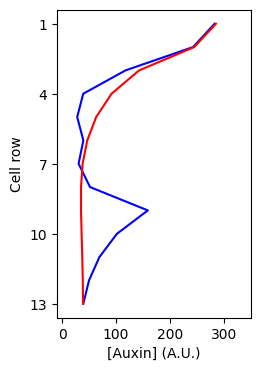

In [928]:
wt = pd.read_csv('../out_batch/batch_2023-04-28_08-49-52__MANUSCRIPT_DUALv4_single/auxin_profile_0_a.csv').head(13)
wt['x'] = data_x
cuc = pd.read_csv('../out_batch/batch_2023-04-28_08-49-52__MANUSCRIPT_DUALv4_single/auxin_profile_0_b.csv').head(13)
wt['x'], cuc['x'] = data_x, data_x

make_individual_plot(sample1_single=wt, sample2_single=cuc)

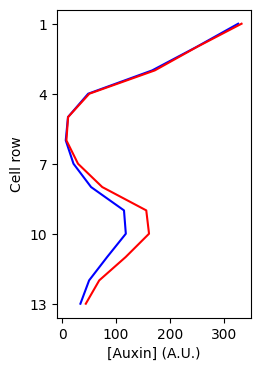

In [929]:
wt = pd.read_csv('../out_batch/batch_2023-04-26_13-33-24__MANUSCRIPT_UTGeffv1_single/auxin_profile_0_a.csv').head(13)
wt['x'] = data_x
cuc = pd.read_csv('../out_batch/batch_2023-04-26_13-33-24__MANUSCRIPT_UTGeffv1_single/auxin_profile_0_c.csv').head(13)
wt['x'], cuc['x'] = data_x, data_x

make_individual_plot(sample1_single=wt, sample2_single=cuc)

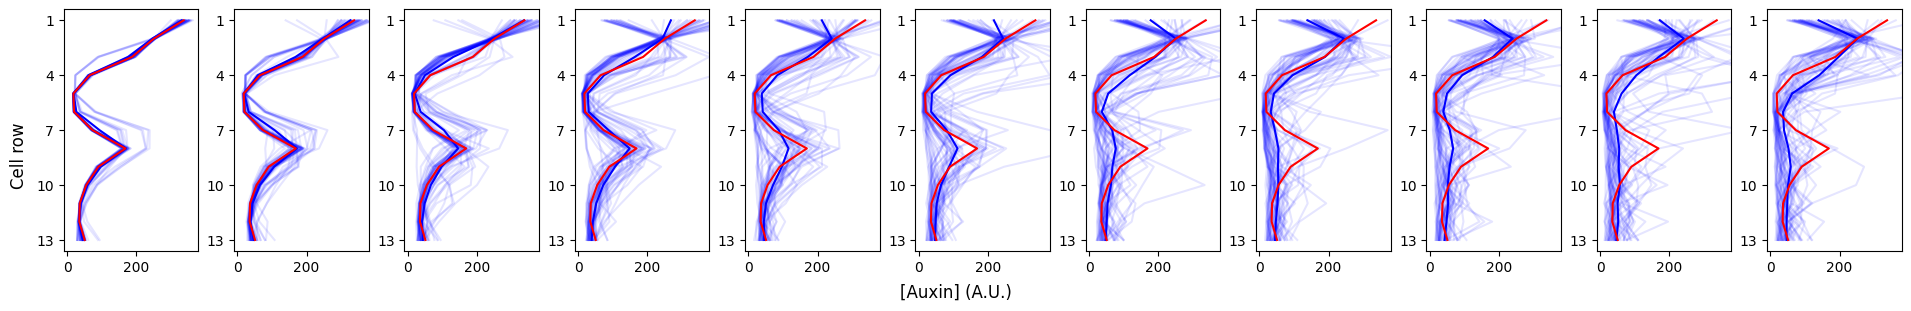

In [930]:
# Individual composite plot for UTGeff
fig3, axes = plt.subplots(1,11, figsize=(19,3), constrained_layout=True)
for data, ax in zip(data_UTGeff[1:], axes.ravel()):
    for col in data.drop(columns=['model', 'noise', 'x']):
        ax.plot(data[col], data['x'], color='blue', alpha=.1)
for mean, ax in zip(all_means_UTGeff[1:], axes.ravel()):
    ax.plot(mean, data_x, color='blue')
for ax in axes.ravel():
    ax.plot(UTGeff_single['0'], data_x, color='red')
for ax in axes.ravel():    
    ax.set_yticks([1,4,7,10,13])
    ax.invert_yaxis()
    ax.set_xlim(-10,380)   
fig3.supxlabel('[Auxin] (A.U.)')
fig3.supylabel('Cell row')
#fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_comapre.png', bbox_inches='tight')
#fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_compare.svg', bbox_inches='tight')

plt.show()

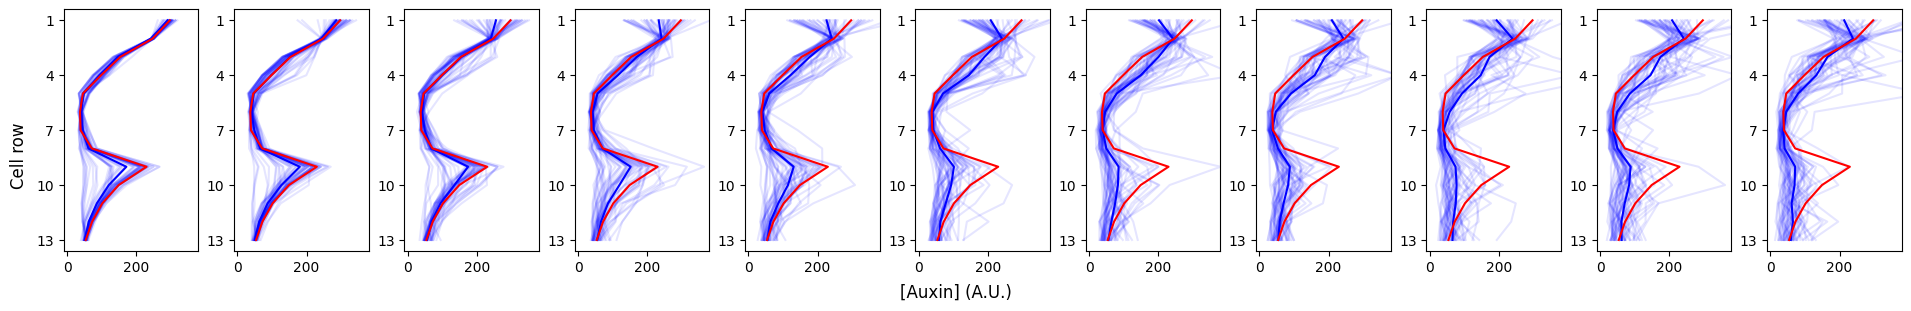

In [931]:
# Individual composite plot for DUAL

fig3, axes = plt.subplots(1,11, figsize=(19,3), constrained_layout=True)
for data, ax in zip(data_DUAL[1:], axes.ravel()):
    for col in data.drop(columns=['model', 'noise', 'x']):
        ax.plot(data[col], data['x'], color='blue', alpha=.1)
for mean, ax in zip(all_means_DUAL[1:], axes.ravel()):
    ax.plot(mean, data_x, color='blue')
for ax in axes.ravel():
    ax.plot(DUAL_single['0'], data_x, color='red')
for ax in axes.ravel():    
    ax.set_yticks([1,4,7,10,13])
    ax.invert_yaxis()
    ax.set_xlim(-10,380)   
fig3.supxlabel('[Auxin] (A.U.)')
fig3.supylabel('Cell row')
#fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_comapre.png', bbox_inches='tight')
#fig1.savefig('00_data/PIN1-CUC1-distTip/scatter_compare.svg', bbox_inches='tight')

plt.show()

In [932]:
# Characterize peaks UTGeff
# Iterate over samples and replicates and extract metrics from the auxin site(s) that form(s) on the margin

def characterize_peaks(model, data):
    '''docstring'''

    all_peaks = pd.DataFrame(columns=['model', 'noise', 'sample', 'replica', 'pos', 'amplitude'])

    for sample_id, sample in enumerate(data):
        noise = noise_levels[sample_id]
        for replica in sample.drop(columns=['model', 'noise', 'x']):

            # Find pos a value of cell row with lowest auxin
            min_val = sample[replica].min()
            
            peaks = list(find_peaks(sample[replica], height = 1, threshold = 1, distance = 1))
            if len(peaks[0]) == 0:
                pass
            if len(peaks[0]) == 1:
                peak_position = data[0]['x'][peaks[0][0]] #peak_pos = sample['x'][peaks[0][0]]
                peak_height = peaks[1]['peak_heights'][0]
                all_peaks = all_peaks.append(pd.DataFrame({'model': model, 'noise': noise, 'sample': sample_id, 'replica': replica, 'pos': float(peak_position), 'amplitude': peak_height - min_val}, index=[0]), ignore_index=True)
            if len(peaks[0]) > 1:
                # Select peak with highest amplitude, excluding the peak that represents the tip of the leaf (cell row)
                # If distal auxin site (rows 0, 1, 2, 3) is detected as peak, remove it from the list of peaks. 
                if peaks[0][0] < 4:
                    peaks[0] = np.delete(peaks[0], 0)
                    peaks[1]['peak_heights'] = np.delete(peaks[1]['peak_heights'], 0)
                # Select highest peak
                max_height_value = np.amax(peaks[1]['peak_heights'])
                max_height_index = np.argmax(peaks[1]['peak_heights'])
                position = peaks[0][max_height_index]+1
                all_peaks = all_peaks.append(pd.DataFrame({'model': model, 'noise': noise, 'sample': sample_id, 'replica': replica, 'pos': float(position), 'amplitude': max_height_value - min_val}, index=[0]), ignore_index=True)
            
            troughs = list(find_peaks(-sample[replica], height = 1, threshold = 1, distance = 1))

    #all_peaks['pos'] = all_peaks['pos'].astype(int)
    #all_peaks[all_peaks['sample'] == 0]
    return(all_peaks)

In [933]:
peaks_UTGeff = characterize_peaks('UTGeff', data_UTGeff)
peaks_UTGeff

,model,noise,sample,replica,pos,amplitude
0,UTGeff,0,0,0,8.0,150.911432
1,UTGeff,2.5,1,0,8.0,151.731692
2,UTGeff,2.5,1,1,8.0,152.208260
3,UTGeff,2.5,1,2,8.0,143.305403
4,UTGeff,2.5,1,3,8.0,139.567110
...,...,...,...,...,...,...
543,UTGeff,27.5,11,45,9.0,246.487097
544,UTGeff,27.5,11,46,7.0,89.588107
545,UTGeff,27.5,11,47,10.0,51.452989
546,UTGeff,27.5,11,48,9.0,78.906361


In [934]:
peaks_DUAL = characterize_peaks('DUAL', data_DUAL)
peaks_DUAL

,model,noise,sample,replica,pos,amplitude
0,DUAL,0,0,0,9.0,192.651640
1,DUAL,2.5,1,0,9.0,146.354945
2,DUAL,2.5,1,1,9.0,194.374586
3,DUAL,2.5,1,2,9.0,188.336467
4,DUAL,2.5,1,3,9.0,193.139786
...,...,...,...,...,...,...
539,DUAL,27.5,11,45,4.0,69.406129
540,DUAL,27.5,11,46,4.0,291.240013
541,DUAL,27.5,11,47,10.0,78.075420
542,DUAL,27.5,11,48,9.0,60.187246


In [935]:
peaks_all = pd.concat([peaks_UTGeff, peaks_DUAL])

In [936]:
# Graph amplitude of peaks both models together

'''fig4, ax = plt.subplots(1,1, figsize=(10,4))
ax.set_ylim(0, 250)
sns.violinplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, alpha=0.3, linewidth=0, color=(.9, .9, .9))
sns.pointplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, ci='sd', linewidth=0, capsize=0, join=False, color='gray', scale=1, errwidth=2)
sns.swarmplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, alpha=0.3, color='blue', size=4)
ax.set_ylabel('Amplitude of emergent auxin peak')
ax.set_xlabel('Noise amplitude in [Auxin] (%)')
ax.set_xticklabels(noise_levels)
ax.get_legend().remove()
plt.show()'''

"fig4, ax = plt.subplots(1,1, figsize=(10,4))\nax.set_ylim(0, 250)\nsns.violinplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, alpha=0.3, linewidth=0, color=(.9, .9, .9))\nsns.pointplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, ci='sd', linewidth=0, capsize=0, join=False, color='gray', scale=1, errwidth=2)\nsns.swarmplot(data=peaks_all, x='sample', y=peaks_all.amplitude, hue=peaks_all.model, dodge=True, alpha=0.3, color='blue', size=4)\nax.set_ylabel('Amplitude of emergent auxin peak')\nax.set_xlabel('Noise amplitude in [Auxin] (%)')\nax.set_xticklabels(noise_levels)\nax.get_legend().remove()\nplt.show()"

In [937]:
# Graph amplitude of peaks

def plot_amplitude_single_model(data):
    fig4, ax = plt.subplots(1,1, figsize=(7,4))
    ax.set_ylim(0, 250)
    sns.violinplot(data=data, x='sample', y=data.amplitude, alpha=0.3, size=3, linewidth=0, color=(.9, .9, .9))
    sns.pointplot(data=data, x='sample', y=data.amplitude, ci='sd', linewidth=0, capsize=0, join=False, color='gray', scale=1, errwidth=2)
    sns.swarmplot(data=data, x='sample', y=data.amplitude, alpha=0.3, color='blue', size=4)
    ax.set_ylabel('Amplitude of emergent auxin peak')
    ax.set_xlabel('Noise amplitude in [Auxin] (%)')
    ax.set_xticklabels(noise_levels)
    plt.show()

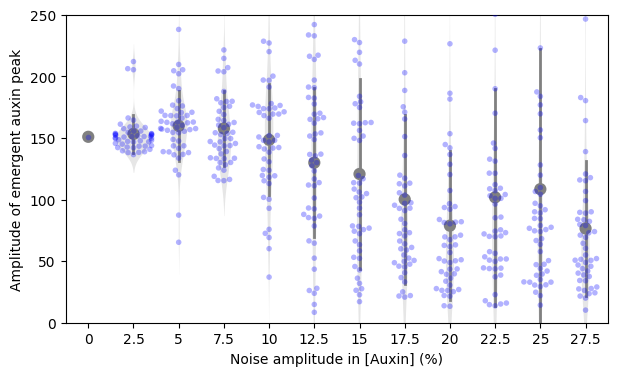

In [938]:
plot_amplitude_single_model(peaks_UTGeff)

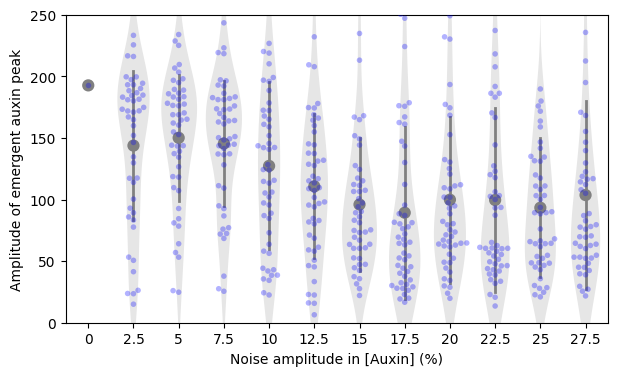

In [939]:
plot_amplitude_single_model(peaks_DUAL)

In [940]:
# Graph position of peaks

def plot_position_single_model(data):
    fig4, ax = plt.subplots(1,1, figsize=(7,4))
    ax.set_ylim(.5, 13.5)
    ax.invert_yaxis()
    sns.violinplot(data=data, x='sample', y=data.pos, alpha=0.3, size=3, linewidth=0, color=(.9, .9, .9))
    sns.pointplot(data=data, x='sample', y=data.pos, ci='sd', linewidth=0, capsize=0, join=False, color='gray', scale=1, errwidth=2)
    sns.swarmplot(data=data, x='sample', y=data.pos, alpha=0.3, color='blue', size=4)
    ax.set_ylabel('Position (cell row) of emergent auxin peak')
    ax.set_xlabel('Noise amplitude in [Auxin] (%)')
    ax.set_xticklabels(noise_levels)
    plt.show()

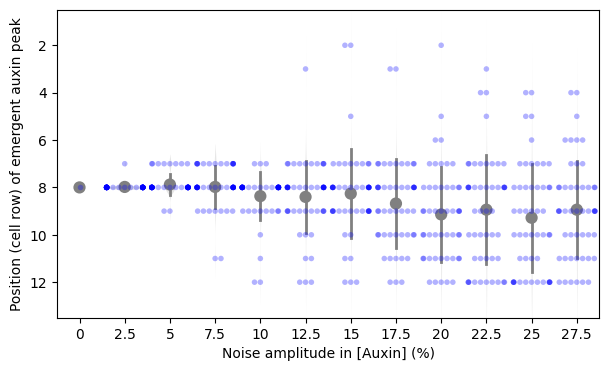

In [941]:
plot_position_single_model(peaks_UTGeff)

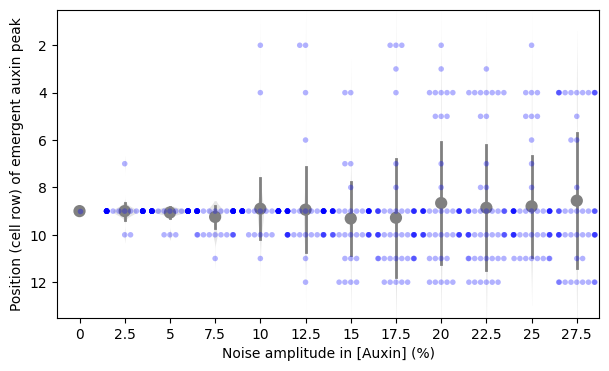

In [942]:
plot_position_single_model(peaks_DUAL)